In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3
import mysql.connector as cnt
#import plotly.express as px

#Tiesiog daugiau biblioteku instaliuojama.

In [3]:
#prisijungimas prie mySQL, ir kursoriaus sukūrimas
DB = cnt.connect(
host = '88.223.121.130',
user='user',
password='slaptazodis',
port=3306,
database='works'
)
C=DB.cursor()

In [17]:
#Turite nusiskaityti iš SQL DB lentelės autopliuslt į Pandas DataFrame gamintoją,
# kainą, pagaminimo datą, ridą, pavarų tipą, variklio informaciją. 
# SQL užklausoje turite atmesti tuos įrašus, kur rida nenurodyta, 
# taip pat palikite tik nesikartojančius įrašus (atranka pagal ID stuleplį - 
# jei ID sutampa - reiškia, jog skelbimas dubliuojasi)
sql="""with T1
as (select *, row_number() over (partition by id) as rc from autopliuslt)
select gamintojas, rida, price as kaina,
pagaminimo_data as data,
pavaros, variklis
from T1
where rc = 1 and rida != 'Nenurodyta' order by gamintojas"""
df = pd.read_sql_query(sql, con=DB)

df['R'] = df['rida'].apply(lambda s: float(s.replace(' ','').replace('km','')))
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))
df['amžius'] = df['data'].apply(lambda s: 2024-int(s[:4]))

df.head()

,gamintojas,rida,kaina,data,pavaros,variklis,R,K,amžius
0,Alfa Romeo,305 000 km,2 100,2007-01,Mechaninė,"1910 cm³, 150 AG (110kW)",305000.0,2100.0,17
1,Alfa Romeo,308 615 km,4 900,2006-04,Mechaninė,"2387 cm³, 200 AG (147kW)",308615.0,4900.0,18
2,Aston Martin,45 000 km,125 000,2015-10,Automatinė,"5935 cm³, 517 AG (380kW)",45000.0,125000.0,9
3,Audi,112 000 km,25 000,2016-06,Automatinė,"3000 cm³, 333 AG (245kW)",112000.0,25000.0,8
4,Audi,450 000 km,7 800,2001-12,Automatinė,"4200 cm³, 360 AG (265kW)",450000.0,7800.0,23


In [5]:
#sql užklausa per pandas sql_query
#sql užklausa per pandas sql_query. Pridetas stulpelis su ridos intervalais 5000
sql="""with T1
as (select *, row_number() over (partition by id) as rc from autopliuslt)
select gamintojas, rida, price as kaina,
pagaminimo_data as data,
pavaros, variklis
from T1
where rc = 1 and rida != 'Nenurodyta' order by gamintojas"""
df = pd.read_sql_query(sql, con=DB)

df['R'] = df['rida'].apply(lambda s: float(s.replace(' ','').replace('km','')))
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))
df['amžius'] = df['data'].apply(lambda s: 2024-int(s[:4]))
df['R5000'] = np.ceil(df['R'] / 5000) * 5000
# galima ir taip:df['ridos_intervalas'] = df['R'].apply(lambda r:np.ceil(r / 5000) * 5000) 
df.head()


,gamintojas,rida,kaina,data,pavaros,variklis,R,K,amžius,R5000
0,Alfa Romeo,305 000 km,2 100,2007-01,Mechaninė,"1910 cm³, 150 AG (110kW)",305000.0,2100.0,17,305000.0
1,Alfa Romeo,308 615 km,4 900,2006-04,Mechaninė,"2387 cm³, 200 AG (147kW)",308615.0,4900.0,18,310000.0
2,Aston Martin,45 000 km,125 000,2015-10,Automatinė,"5935 cm³, 517 AG (380kW)",45000.0,125000.0,9,45000.0
3,Audi,112 000 km,25 000,2016-06,Automatinė,"3000 cm³, 333 AG (245kW)",112000.0,25000.0,8,115000.0
4,Audi,450 000 km,7 800,2001-12,Automatinė,"4200 cm³, 360 AG (265kW)",450000.0,7800.0,23,450000.0


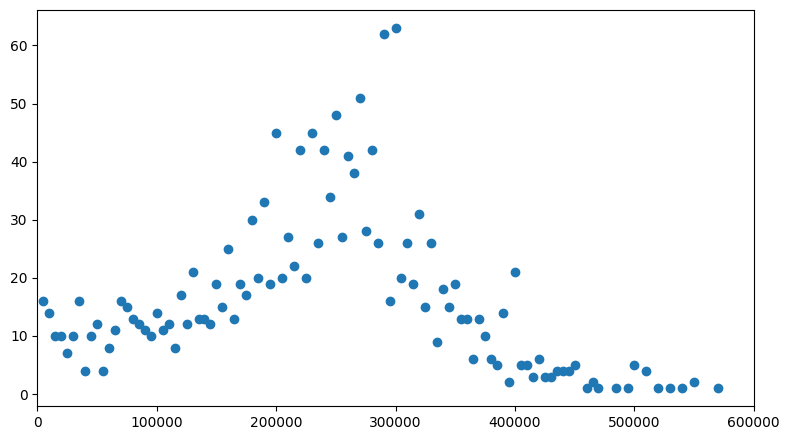

In [6]:
#+ prie to kos buvo
#  groupby(), agregacijos (mean, median), reset_index()
#  head() su groupby()

dfg = df[['R5000','K']].groupby('R5000').count().reset_index()

dfg.head()
fig, axis = plt.subplots(figsize=(8,4.5))
#plotting code:

axis.scatter(dfg['R5000'], dfg['K'])
axis.set_xlim(0, 6e5)
#axis.legend(loc='best')
#axis.ticklabel_format(style='plain')
fig.tight_layout()
plt.show()

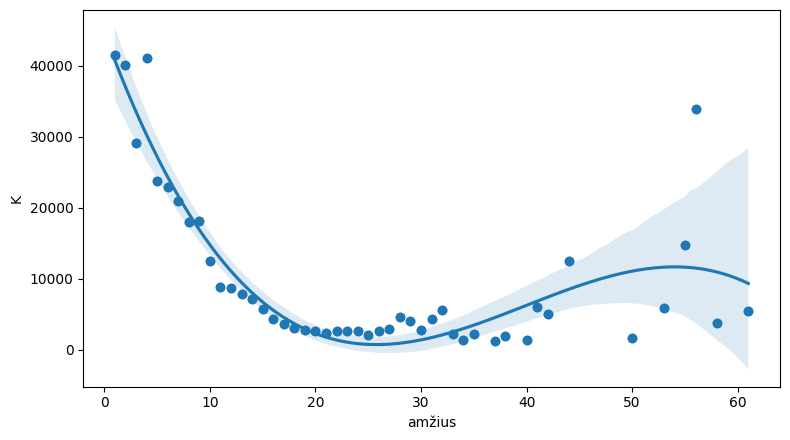

In [12]:
# Vizualizuokite, kaip nuo amžiaus priklauso automobilių kaina.
# Panaudokite seaborn regplot, kad pademonstruotumėte trendą

dfg = df[['amžius','K']].groupby('amžius').mean().reset_index()

dfg.head()
fig, axis = plt.subplots(figsize=(8,4.5))
#plotting code:

axis.scatter(dfg['amžius'], dfg['K'])
axis=sns.regplot(data=dfg, x='amžius', y='K', order=3)
#axis.set_xlim(0, 6e5)
#axis.legend(loc='best')
#axis.ticklabel_format(style='plain')
fig.tight_layout()
plt.show()


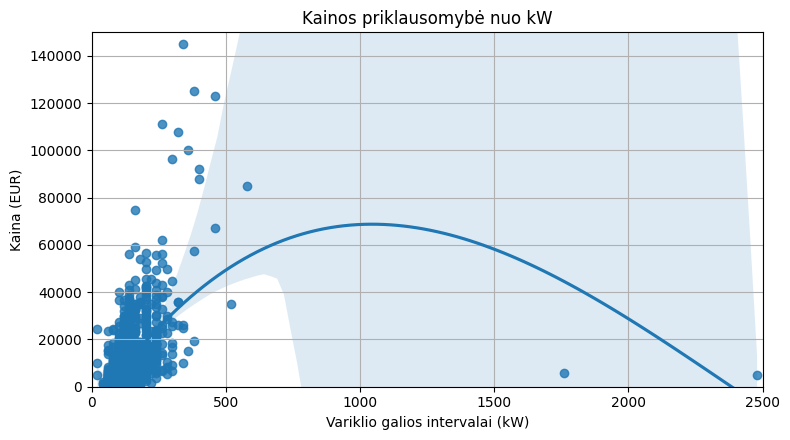

In [43]:
# Nubrezti kainos priklausomybes nuo KW . Galios intervalai po 20 kW
#kaina nevidurkinta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SQL užklausa
sql = """
    WITH T1 AS (
    SELECT *, row_number() OVER (partition by id) as rc
    FROM autopliuslt
)
SELECT gamintojas, rida, price AS kaina, pagaminimo_data AS data,
       pavaros, variklis
FROM T1
WHERE rc = 1 
  AND variklis LIKE '%kW%'  -- Pašaliname įrašus be kW informacijos
ORDER BY gamintojas
"""
# Nuskaitome duomenis į Pandas DataFrame
df = pd.read_sql_query(sql, con=DB)

# Konvertuojame kainą į skaičių
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))

# Ištraukiame kW iš variklio informacijos
df['variklis'] = df['variklis'].apply(lambda x: float(x.split('(')[1].replace('kW)', '')))

# Apskaičiuojame variklio galią pagal intervalus po 25 kW
df['V25'] = np.ceil(df['variklis'] / 20) * 20

# Sukuriame figūrą ir ašį grafikui braižyti
fig, axis = plt.subplots(figsize=(8, 4.5))

# Braižome regresijos grafiką
sns.regplot(data=df, x='V25', y='K', order=3, ax=axis)

# Papildome grafiką pavadinimais ir tinkamai sutvarkome grafiką
axis.set_title('Kainos priklausomybė nuo kW')
axis.set_xlabel('Variklio galios intervalai (kW)')
axis.set_xlim(0, 2500)
axis.set_ylabel('Kaina (EUR)')
axis.set_ylim(0, 15e4)
axis.grid(True)

# Parodome grafiką
plt.tight_layout()
plt.show()


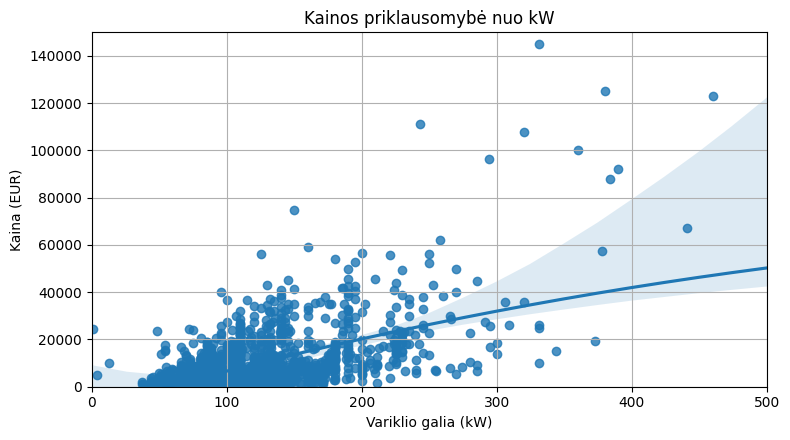

In [31]:
# Nubrezti kainos priklausomybes nuo KW . 
# Be galios intervalu, neskaiciuojant vidutines kainos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SQL užklausa
sql = """
    WITH T1 AS (
    SELECT *, row_number() OVER (partition by id) as rc
    FROM autopliuslt
)
SELECT gamintojas, rida, price AS kaina, pagaminimo_data AS data,
       pavaros, variklis
FROM T1
WHERE rc = 1 
  AND variklis LIKE '%kW%'  -- Pašaliname įrašus be kW informacijos
ORDER BY gamintojas
"""
# Nuskaitome duomenis į Pandas DataFrame
df = pd.read_sql_query(sql, con=DB)

# Konvertuojame kainą į skaičių
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))

# Ištraukiame kW iš variklio informacijos
df['variklis'] = df['variklis'].apply(lambda x: float(x.split('(')[1].replace('kW)', '')))

# Sukuriame figūrą ir ašį grafikui braižyti
fig, axis = plt.subplots(figsize=(8, 4.5))

# Braižome regresijos grafiką
sns.regplot(data=df, x='variklis', y='K', order=3, ax=axis)

# Papildome grafiką pavadinimais ir tinkamai sutvarkome grafiką
axis.set_title('Kainos priklausomybė nuo kW')
axis.set_xlabel('Variklio galia (kW)')
axis.set_xlim(0, 500)
axis.set_ylabel('Kaina (EUR)')
axis.set_ylim(0, 15e4)
axis.grid(True)

# Parodome grafiką
plt.tight_layout()
plt.show()

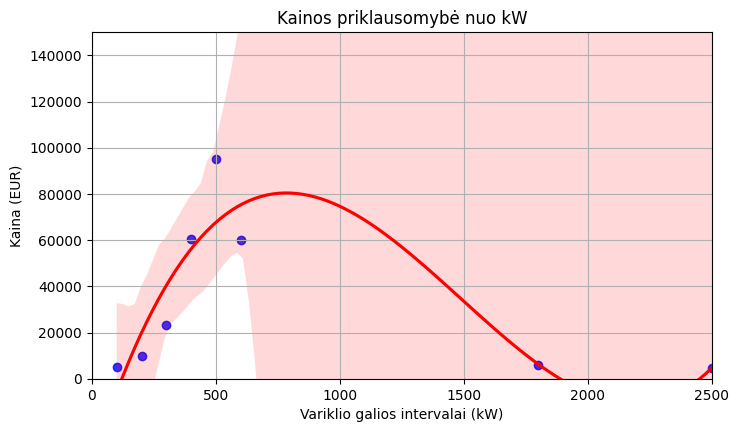

In [46]:
# Nubrezti kainos priklausomybes nuo KW . Galios intervalai po 100.
# Kaina vidurkinta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SQL užklausa
sql = """
    WITH T1 AS (
    SELECT *, row_number() OVER (partition by id) as rc
    FROM autopliuslt
)
SELECT gamintojas, rida, price AS kaina, pagaminimo_data AS data,
       pavaros, variklis
FROM T1
WHERE rc = 1 
  AND variklis LIKE '%kW%'  -- Pašaliname įrašus be kW informacijos
ORDER BY gamintojas
"""
# Nuskaitome duomenis į Pandas DataFrame
df = pd.read_sql_query(sql, con=DB)

# Konvertuojame kainą į skaičių
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))

# Ištraukiame kW iš variklio informacijos
df['variklis'] = df['variklis'].apply(lambda x: float(x.split('(')[1].replace('kW)', '')))

# Apskaičiuojame variklio galią pagal intervalus po 25 kW
df['V25'] = np.ceil(df['variklis'] / 100) * 100
# Sukuriame grupuotą duomenų rinkinį pagal V25
dfg = df[['V25','K']].groupby('V25').mean().reset_index()
# Sukuriame figūrą ir ašį grafikui braižyti
fig, axis = plt.subplots(figsize=(8, 4.5))

# Braižome regresijos grafiką
sns.regplot(data=dfg, x='V25', y='K', order=3, ax=axis,
            scatter_kws={'color': 'blue'},  # Taškų spalva
            line_kws={'color': 'red'})

# Papildome grafiką pavadinimais ir tinkamai sutvarkome grafiką
axis.set_title('Kainos priklausomybė nuo kW')
axis.set_xlabel('Variklio galios intervalai (kW)')
axis.set_xlim(0, 2500)
axis.set_ylabel('Kaina (EUR)')
axis.set_ylim(0, 15e4)
axis.grid(True)


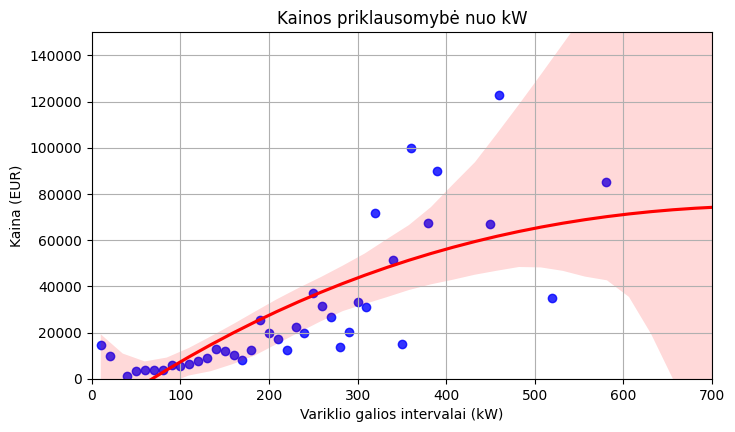

In [48]:
# Nubrezti kainos priklausomybes nuo KW . Galios intervalai po 10.
# Kaina suvidurkinta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SQL užklausa
sql = """
    WITH T1 AS (
    SELECT *, row_number() OVER (partition by id) as rc
    FROM autopliuslt
)
SELECT gamintojas, rida, price AS kaina, pagaminimo_data AS data,
       pavaros, variklis
FROM T1
WHERE rc = 1 
  AND variklis LIKE '%kW%'  -- Pašaliname įrašus be kW informacijos
ORDER BY gamintojas
"""
# Nuskaitome duomenis į Pandas DataFrame
df = pd.read_sql_query(sql, con=DB)

# Konvertuojame kainą į skaičių
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))

# Ištraukiame kW iš variklio informacijos
df['variklis'] = df['variklis'].apply(lambda x: float(x.split('(')[1].replace('kW)', '')))

# Apskaičiuojame variklio galią pagal intervalus po 10 kW
df['V25'] = np.ceil(df['variklis'] / 10) * 10
# Sukuriame grupuotą duomenų rinkinį pagal V25
dfg = df[['V25','K']].groupby('V25').mean().reset_index()
# Sukuriame figūrą ir ašį grafikui braižyti
fig, axis = plt.subplots(figsize=(8, 4.5))

# Braižome regresijos grafiką
sns.regplot(data=dfg, x='V25', y='K', order=3, ax=axis,
            scatter_kws={'color': 'blue'},  # Taškų spalva
            line_kws={'color': 'red'})

# Papildome grafiką pavadinimais ir tinkamai sutvarkome grafiką
axis.set_title('Kainos priklausomybė nuo kW')
axis.set_xlabel('Variklio galios intervalai (kW)')
axis.set_xlim(0, 700)
axis.set_ylabel('Kaina (EUR)')
axis.set_ylim(0, 15e4)
axis.grid(True)


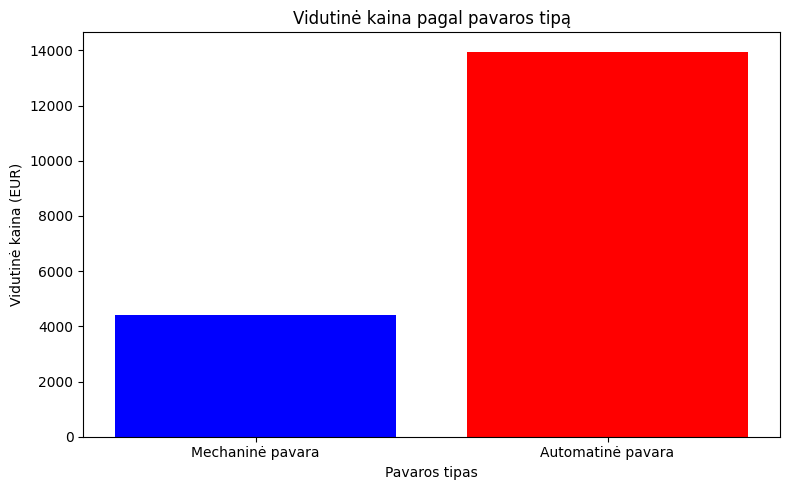

In [18]:
#kas brangiau - mechaninė ar automatinė? 
#Kiek vienetų rinkoje buvo su mechan, ir su automat?
#sql užklausa per pandas sql_query
#sql užklausa per pandas sql_query. Pridetas stulpelis su ridos intervalais 5000
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SQL užklausa
sql = """
    WITH T1 AS (
    SELECT *, row_number() OVER (partition by id) as rc
    FROM autopliuslt
)
SELECT gamintojas, rida, price AS kaina, pagaminimo_data AS data,
       pavaros, variklis
FROM T1
WHERE rc = 1 
  AND variklis LIKE '%kW%'  -- Pašaliname įrašus be kW informacijos
ORDER BY gamintojas
"""

# Konvertuojame kainą į skaičių
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ', '').replace('km', '')))

# Apskaičiuojame vidutinę kainą mechaninėms ir automatinėms pavaroms
vid_kaina_mechanine = df[df['pavaros'] == 'Mechaninė']['K'].mean()
vid_kaina_automatine = df[df['pavaros'] == 'Automatinė']['K'].mean()

# Suskaičiuojame kiek buvo mechaninių ir automatinių transporto priemonių
kiekis_mechanine = df[df['pavaros'] == 'Mechaninė'].count()
kiekis_automatine = df[df['pavaros'] == 'Automatinė'].count()

# Išvedame vidutines kainas ir kiekius
#print(f"Vidutinė mechaninės pavaros kaina: {vid_kaina_mechanine:.2f} EUR")
#print(f"Vidutinė automatinės pavaros kaina: {vid_kaina_automatine:.2f} EUR")
#print(f"Mechaninių automobilių kiekis: {kiekis_mechanine}")
#print(f"Automatinių automobilių kiekis: {kiekis_automatine}")


# Sukuriame figūrą ir ašį grafikui braižyti
fig, ax = plt.subplots(figsize=(8, 5))

# Braižome kainos kreives
ax.bar(['Mechaninė pavara', 'Automatinė pavara'], 
       [vid_kaina_mechanine, vid_kaina_automatine], color=['blue', 'red'])

# Pridėkime pavadinimus
ax.set_title('Vidutinė kaina pagal pavaros tipą')
ax.set_xlabel('Pavaros tipas')
ax.set_ylabel('Vidutinė kaina (EUR)')

# Parodome grafiką
plt.tight_layout()
plt.show()

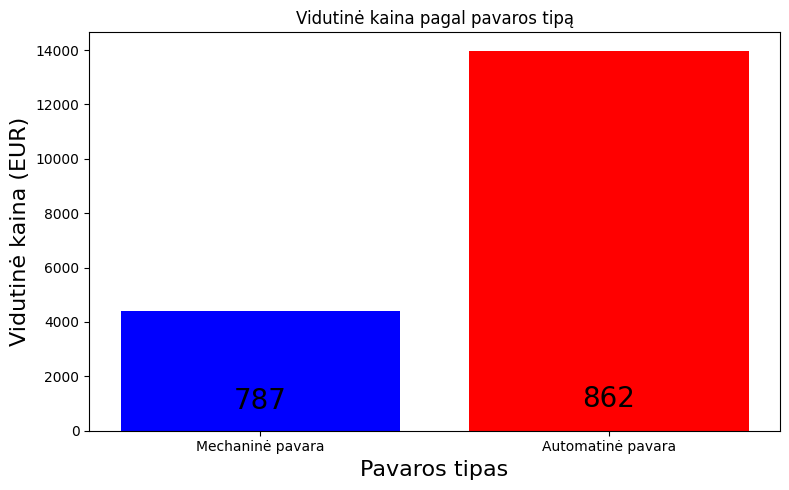

In [26]:
#kas brangiau - mechaninė ar automatinė? 
#Kiek vienetų rinkoje buvo su mechan, ir su automat?
#sql užklausa per pandas sql_query
#sql užklausa per pandas sql_query. Pridetas stulpelis su ridos intervalais 5000
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SQL užklausa
sql = """
    WITH T1 AS (
    SELECT *, row_number() OVER (partition by id) as rc
    FROM autopliuslt
)
SELECT gamintojas, rida, price AS kaina, pagaminimo_data AS data,
       pavaros, variklis
FROM T1
WHERE rc = 1 
  AND variklis LIKE '%kW%'  -- Pašaliname įrašus be kW informacijos
ORDER BY gamintojas
"""

# Konvertuojame kainą į skaičių
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ', '').replace('km', '')))

# Apskaičiuojame vidutinę kainą mechaninėms ir automatinėms pavaroms
vid_kaina_mechanine = df[df['pavaros'] == 'Mechaninė']['K'].mean()
vid_kaina_automatine = df[df['pavaros'] == 'Automatinė']['K'].mean()

# Suskaičiuojame kiek buvo mechaninių ir automatinių transporto priemonių
kiekis_mechanine = df[df['pavaros'] == 'Mechaninė'].shape[0]
kiekis_automatine = df[df['pavaros'] == 'Automatinė'].shape[0]

# Išvedame vidutines kainas ir kiekius
#print(f"Vidutinė mechaninės pavaros kaina: {vid_kaina_mechanine:.2f} EUR")
#print(f"Vidutinė automatinės pavaros kaina: {vid_kaina_automatine:.2f} EUR")
#print(f"Mechaninių automobilių kiekis: {kiekis_mechanine}")
#print(f"Automatinių automobilių kiekis: {kiekis_automatine}")


# Sukuriame figūrą ir ašį grafikui braižyti
fig, ax = plt.subplots(figsize=(8, 5))

# Braižome kainos kreives
ax.bar(['Mechaninė pavara', 'Automatinė pavara'], 
       [vid_kaina_mechanine, vid_kaina_automatine], color=['blue', 'red'])

# Pridėkime pavadinimus
ax.set_title('Vidutinė kaina pagal pavaros tipą')
ax.set_xlabel('Pavaros tipas',fontsize=16)
ax.set_ylabel('Vidutinė kaina (EUR)', fontsize=16)
# Pridedame etiketes prie stulpelių
for i, v in enumerate([kiekis_mechanine, kiekis_automatine]):
    plt.text(i, v + 20, str(v), ha='center', fontsize=20)
# Parodome grafiką
plt.tight_layout()
plt.show()

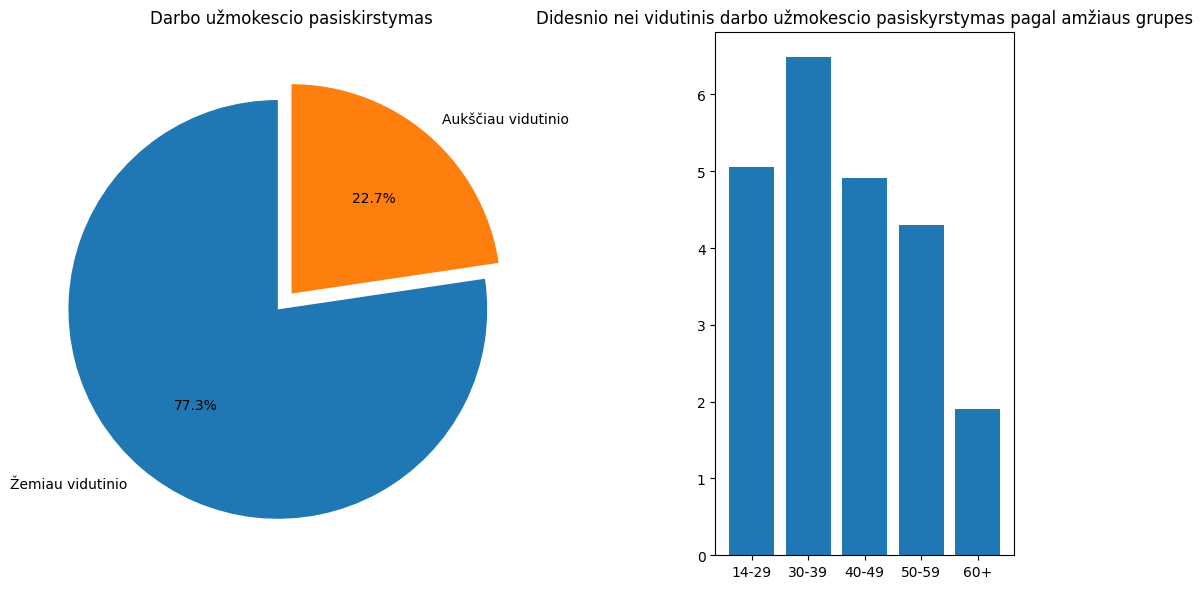

In [14]:

# parašykite funkciją,kuriai galėtumėte nurodyti savo norimus duomenis kaip list arba array
#  ir ji nubraižytų bar-of-pie tipo grafiką.
#  funkcijos pavadinimas BarOfPie(), argumentus, jų tipus parenkate patys

# https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html

# BarOfPie(pie=[], bar=[], bar_labels=[], pie_labels=[])
import matplotlib.pyplot as plt

def BarOfPie(pie, bar, pie_labels, bar_labels, explode_index: int):
    # Sukuriame subplots su skirtingu dydžių santykiu (3:1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})

    # Pagrindinė diagrama
    explode = [0.1 if i == explode_index else 0 for i in range(len(pie))]
    wedges, texts, autotexts = ax1.pie(pie, labels=pie_labels, autopct='%1.1f%%', startangle=90, explode=explode)
    ax1.set_title("Darbo užmokescio pasiskirstymas")

    # Bar diagram
    ax2.bar(bar_labels, bar)
    ax2.set_title("Didesnio nei vidutinis darbo užmokescio pasiskyrstymas pagal amžiaus grupes")
   
    # Parodome abu grafikus
    plt.tight_layout()
    plt.show()

# Naudojimo pavyzdys
pie = [77.34, 22.66]  # Pyrago diagramos duomenys
pie_labels = ['Žemiau vidutinio', 'Aukščiau vidutinio']
bar = [5.05, 6.49, 4.91, 4.30, 1.91]  # Bar diagramos duomenys
bar_labels = ['14-29', '30-39', '40-49', '50-59', '60+']
#Kvietimas
BarOfPie(pie=pie, bar=bar, pie_labels=pie_labels, bar_labels=bar_labels, explode_index=0)

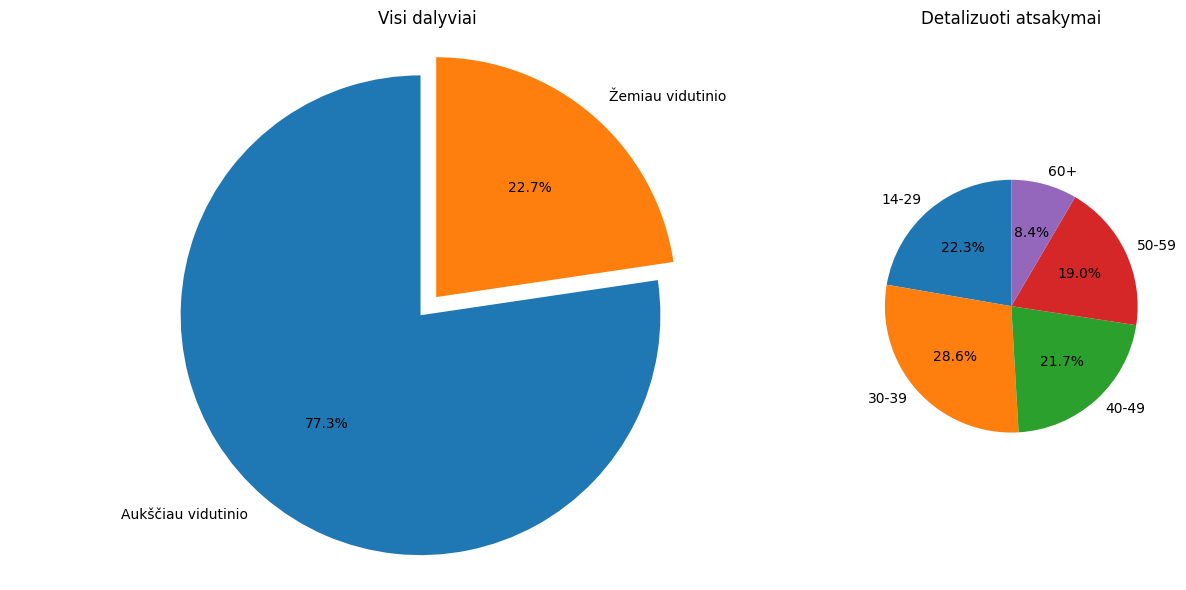

In [23]:
# parašykite funkciją,kuriai galėtumėte nurodyti savo norimus duomenis kaip list arba array
#  ir ji nubraižytų pie-of-pie tipo grafiką.
#  funkcijos pavadinimas PieOfPie(), argumentus, jų tipus parenkate patys
# https://stackoverflow.com/questions/59089531/generating-compound-pie-or-pie-of-pie-charts
import matplotlib.pyplot as plt

def PieOfPie(pie=[], pie_s=[], pie_labels=[], pie_s_labels=[], explode_index: int = 0):
     
    # Sukuriame subplots su skirtingu dydžių santykiu (3:1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})

    # Pagrindinė diagrama
    explode = [0.1 if i == explode_index else 0 for i in range(len(pie))]
    wedges, texts, autotexts = ax1.pie(pie, labels=pie_labels, autopct='%1.1f%%', startangle=90, explode=explode)
    ax1.set_title("Visi dalyviai")

    # Detalizuota bar diagrama (mažesnis)
    ax2.pie(pie_s, labels=pie_s_labels, autopct='%1.1f%%', startangle=90)
    ax2.set_title("Detalizuoti atsakymai")

    # Užtikriname, kad abu grafikai būtų apvalūs
    ax1.axis('equal')
    ax2.axis('equal')

    # Parodome abu grafikus
    plt.tight_layout()
    plt.show()

# Naudojimo pavyzdys
labels = ['Aukščiau vidutinio', 'Žemiau vidutinio']
sizes = [77.34, 22.66]
detailed_labels = ['14-29', '30-39', '40-49', '50-59', '60+']  # Pavyzdiniai detalizuoti duomenys
detailed_sizes = [5.05, 6.49, 4.91, 4.30, 1.91]

# Kvietimas 
PieOfPie(sizes, detailed_sizes, labels, detailed_labels, explode_index=0)


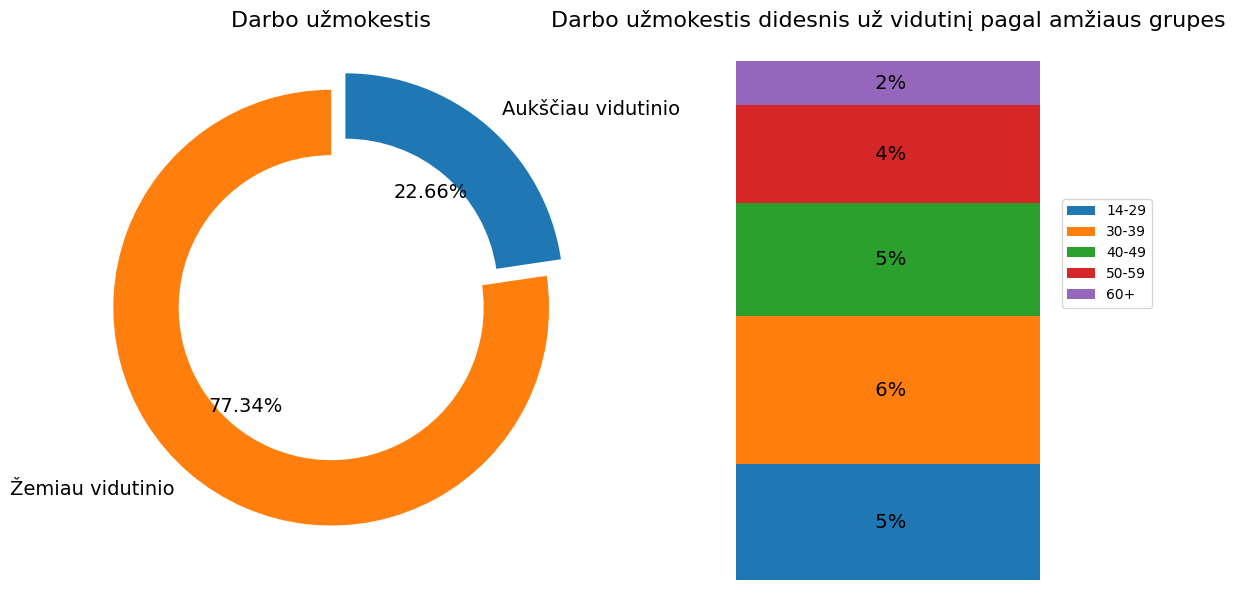

In [4]:
# parašykite funkciją,kuriai galėtumėte nurodyti savo norimus duomenis kaip list arba array
#  ir ji nubraižytų pie-of-pie tipo grafiką.
#  funkcijos pavadinimas PieOfPie(), argumentus, jų tipus parenkate patys

# https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html
# 
import matplotlib.pyplot as plt

def BarOfPie2(pie=[], bar=[], pie_labels=[], bar_labels=[], explode_index: int=0):
    # Sukuriame subplots su skirtingu dydžių santykiu (2:1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

    # Pagrindinė diagrama
    explode = [0.1 if i == explode_index else 0 for i in range(len(pie))]
    wedges, texts, autotexts = ax1.pie(pie, labels=pie_labels, autopct='%1.2f%%', startangle=90, explode=explode,
                                       colors=['#ff7f0e', '#1f77b4', '#2ca02c'], wedgeprops=dict(width=0.3), textprops={'fontsize': 14})
    ax1.set_title("Darbo užmokestis", fontsize=16)

    # Juostų diagrama šalia pagrindines diagramos
    bottom = 0
    width=0.2# baru plotis,kuris nesireguliuoja, nors turetu...
    for j, (height, label) in enumerate(zip(bar, bar_labels)):
        bc = ax2.bar(0, height, width, bottom=bottom, label=label)
        bottom += height  # Kiekvieną kartą padidiname viršutinę ribą
        ax2.bar_label(bc, labels=[f"{height:2.0f}%"], label_type='center', fontsize=14)
       # Pašaliname ašis ir jų žymes
    ax2.axis('off')  # Visiškai pašaliname ašis 
    # Papildomi nustatymai
    ax2.set_title("Darbo užmokestis didesnis už vidutinį pagal amžiaus grupes", fontsize=16)
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.6))#Cia apaaiskina, kokios amziaus grupes

    # Parodome abu grafikus
    plt.tight_layout()
    plt.show()

# Naudojimo pavyzdys
pie = [77.34, 22.66]  # Pagrindines diagramos duomenys
pie_labels = ['Žemiau vidutinio', 'Aukščiau vidutinio']
bar = [5.05, 6.49, 4.91, 4.30, 1.91]  # Bar diagramos duomenys
bar_labels = ['14-29', '30-39', '40-49', '50-59', '60+']
BarOfPie2(pie=pie, bar=bar, pie_labels=pie_labels, bar_labels=bar_labels, explode_index=1)

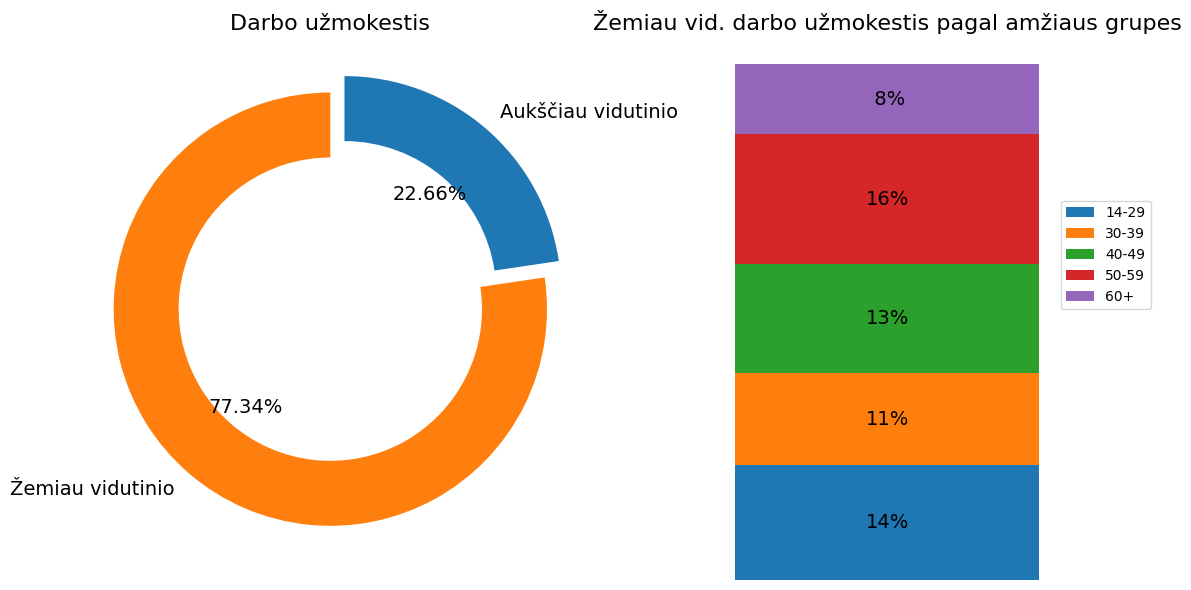

In [35]:
# BarOfPie(pie=[], bar=[], bar_labels=[], pie_labels=[])
# parašykite funkciją,kuriai galėtumėte nurodyti savo norimus duomenis kaip list arba array
#  ir ji nubraižytų pie-of-bar tipo grafiką.
#^iua atveju parodo dar ir pasiskirstyma pagal grupes ir zemiausia darbo u=mokest5 gavusius.
#  funkcijos pavadinimas BarofPie2(), argumentus, jų tipus parenkate patys

# https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html
# 
import matplotlib.pyplot as plt

def BarOfPie2(pie=[], bar=[], bar_1=[], pie_labels=[], bar_labels=[], explode_index: int=0):
    # Sukuriame subplots su skirtingu dydžių santykiu (2:1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

    # Pagrindinė diagrama
    explode = [0.1 if i == explode_index else 0 for i in range(len(pie))]
    wedges, texts, autotexts = ax1.pie(pie, labels=pie_labels, autopct='%1.2f%%', startangle=90, explode=explode,
                                       colors=['#ff7f0e', '#1f77b4', '#2ca02c'], wedgeprops=dict(width=0.3), textprops={'fontsize': 14})
    ax1.set_title("Darbo užmokestis", fontsize=16)

    # Pasirenkame, kokius duomenis rodyti bar grafike
    if explode_index == 0:
        bar_data = bar  # Aukščiausias darbo užmokestis
        ax2.set_title("Aukščiau vid.darbo užmokestis pagal amžiaus grupes", fontsize=16)
    else:
        bar_data = bar_1  # Žemiausias darbo užmokestis
        ax2.set_title("Žemiau vid. darbo užmokestis pagal amžiaus grupes", fontsize=16)

    # Juostų diagrama šalia pagrindinės diagramos
    bottom = 0
    width = 1  # Barų plotis
    for height, label in zip(bar_data, bar_labels):
        bc = ax2.bar(0, height, width, bottom=bottom, label=label)  # Visos juostos sukraunamos ant x = 0
        bottom += height  # Kiekvieną kartą padidiname apatinę ribą (sukrauname juostas)
        ax2.bar_label(bc, labels=[f"{height:2.0f}%"], label_type='center', fontsize=14)

    # Pašaliname ašis ir jų žymes
    ax2.axis('off')  # Visiškai pašaliname ašis 
    # Papildomi nustatymai
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.6))  # Paaiškina, kokios amžiaus grupės

    # Parodome abu grafikus
    plt.tight_layout()
    plt.show()

# Naudojimo pavyzdys
pie = [77.34, 22.66]  # Pagrindinės diagramos duomenys
pie_labels = ['Žemiau vidutinio', 'Aukščiau vidutinio']
bar = [5.05, 6.49, 4.91, 4.30, 1.91]  # # Aukščiau vid darbo užmokestis
bar_1 = [13.86, 10.96, 13.12, 15.62, 8.41]   # Žemiau vid. darbo užmokestis
bar_labels = ['14-29', '30-39', '40-49', '50-59', '60+']

BarOfPie2(pie=pie, bar=bar, bar_1=bar_1, pie_labels=pie_labels, bar_labels=bar_labels, explode_index=1)

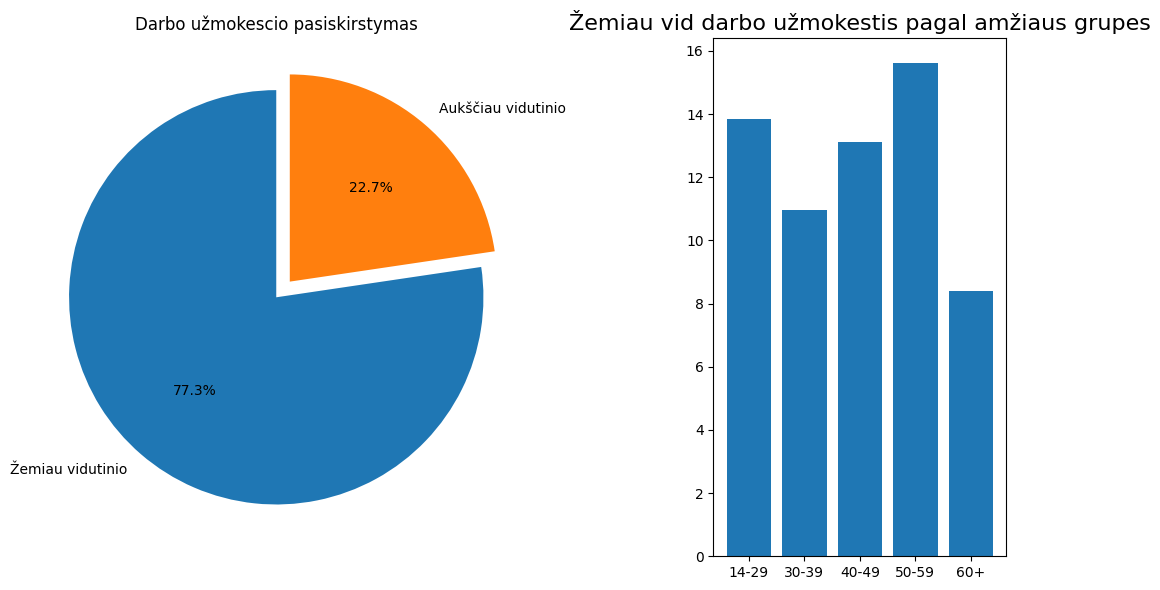

In [2]:
# parašykite funkciją,kuriai galėtumėte nurodyti savo norimus duomenis kaip list arba array
#  ir ji nubraižytų bar-of-pie tipo grafiką. Rodo paskirstyma pagal amziaus grupes tiek daugiau, tiek maziau uz vidutini gaunancius
#  funkcijos pavadinimas BarOfPie(), argumentus, jų tipus parenkate patys

# https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html

# BarOfPie(pie=[], bar=[], bar_labels=[], pie_labels=[])
import matplotlib.pyplot as plt

def BarOfPie(pie=[], bar=[], bar_1=[], pie_labels=[], bar_labels=[], explode_index: int=0):
    # Sukuriame subplots su skirtingu dydžių santykiu (3:1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})

    # Pagrindinė diagrama
    explode = [0.1 if i == explode_index else 0 for i in range(len(pie))]
    wedges, texts, autotexts = ax1.pie(pie, labels=pie_labels, autopct='%1.1f%%', startangle=90, explode=explode)
    ax1.set_title("Darbo užmokescio pasiskirstymas")

    # Pasirenkame, kokius duomenis rodyti bar grafike
    if explode_index == 0:
        bar_data = bar  # Aukščiau vid. darbo užmokestis
        ax2.set_title("Aukščiau vid. darbo užmokestis pagal amžiaus grupes", fontsize=16)
    else:
        bar_data = bar_1  # Žemiau vid. darbo užmokestis
        ax2.set_title("Žemiau vid darbo užmokestis pagal amžiaus grupes", fontsize=16)

    # Bar diagramos piešimas
    ax2.bar(bar_labels, bar_data)  # Naudojame bar_data, kuris kinta priklausomai nuo explode_index
    
    # Parodome abu grafikus
    plt.tight_layout()
    plt.show()

# Naudojimo pavyzdys
pie = [77.34, 22.66]  # Pyrago diagramos duomenys
pie_labels = ['Žemiau vidutinio', 'Aukščiau vidutinio']
bar = [5.05, 6.49, 4.91, 4.30, 1.91]  # Bar diagramos duomenys (Aukščiau vid.)
bar_1 = [13.86, 10.96, 13.12, 15.62, 8.41]  # Žemiau vid. darbo užmokestis
bar_labels = ['14-29', '30-39', '40-49', '50-59', '60+']

# Kvietimas
BarOfPie(pie=pie, bar=bar, bar_1=bar_1, pie_labels=pie_labels, bar_labels=bar_labels, explode_index=1)


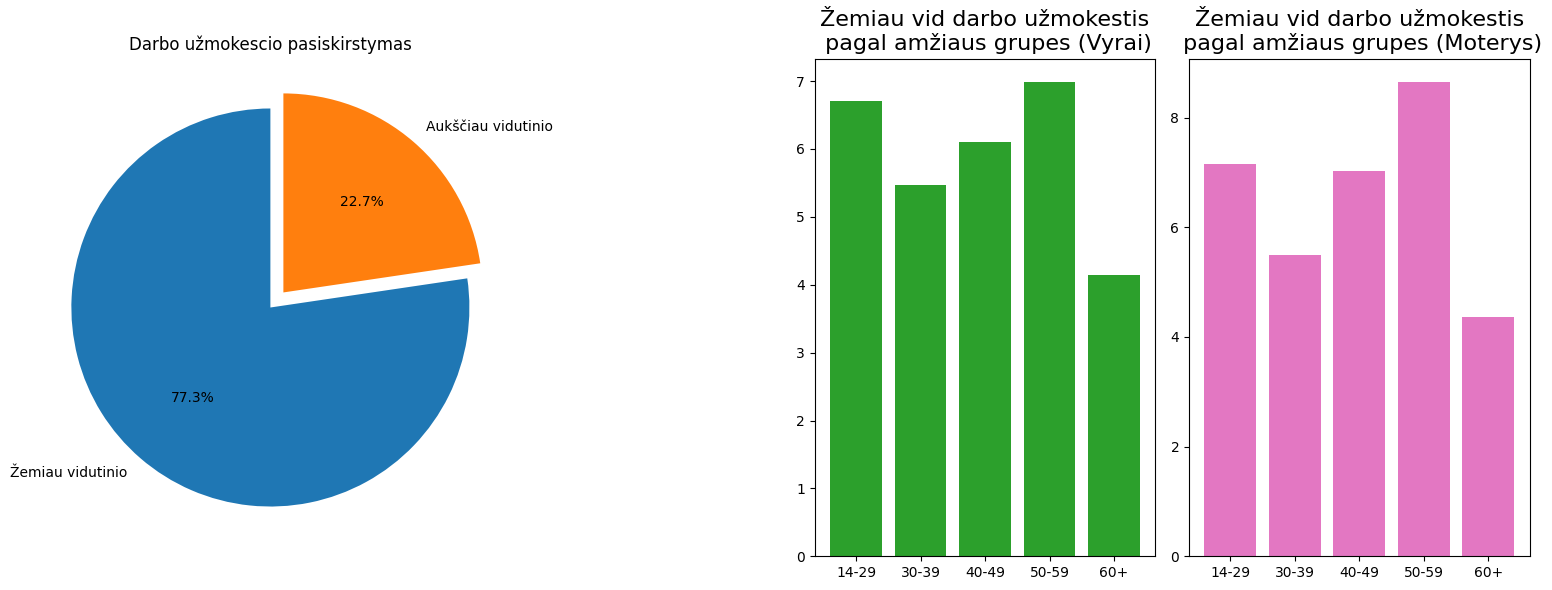

In [40]:
# parašykite funkciją,kuriai galėtumėte nurodyti savo norimus duomenis kaip list arba array
#  ir ji nubraižytų bar-of-pie tipo grafiką. Rodo paskirstyma pagal amziaus 
# grupes tiek daugiau, tiek maziau uz vidutini gaunancius. Bei PAGAL LYTI.
#  funkcijos pavadinimas BarOfPie(), argumentus, jų tipus parenkate patys

# https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html

import matplotlib.pyplot as plt

def BarOfPie(pie=[], bar_M=[], bar_F=[], bar_1_M=[], bar_1_F=[], pie_labels=[], bar_labels=[], explode_index: int=0):
    # Sukuriame subplots su skirtingu dydžių santykiu (3:1:1)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [3, 1, 1]})

    # Pagrindinė diagrama (Pyragas)
    explode = [0.1 if i == explode_index else 0 for i in range(len(pie))]
    wedges, texts, autotexts = ax1.pie(pie, labels=pie_labels, autopct='%1.1f%%', startangle=90, explode=explode)
    ax1.set_title("Darbo užmokescio pasiskirstymas")

    # Pasirenkame, kokius duomenis rodyti bar grafike
    if explode_index == 0:
        bar_data_M = bar_M  # Aukščiau vid. darbo užmokestis Vyrai
        bar_data_F = bar_F  # Aukščiau vid. darbo užmokestis Moterys
        ax2.set_title("Aukščiau vid. darbo užmokestis pagal amžiaus grupes (Vyrai)", fontsize=16)
        ax3.set_title("Aukščiau vid. darbo užmokestis pagal amžiaus grupes (Moterys)", fontsize=16)
    else:
        bar_data_M = bar_1_M  # Žemiau vid. darbo užmokestis Vyrai
        bar_data_F = bar_1_F  # Žemiau vid. darbo užmokestis Moterys
        ax2.set_title("Žemiau vid darbo užmokestis\n pagal amžiaus grupes (Vyrai)", fontsize=16)
        ax3.set_title("Žemiau vid darbo užmokestis\n pagal amžiaus grupes (Moterys)", fontsize=16)

    # Bar diagramos piešimas vyrams (Naudojame skirtingas spalvas)
    colors_M = [ '#2ca02c']  # Spalvos vyrams
    ax2.bar(bar_labels, bar_data_M, color=colors_M)  # Naudojame bar_data_M su spalvomis

    # Bar diagramos piešimas moterims (Naudojame skirtingas spalvas)
    colors_F = ['#e377c2']  # Spalvos moterims
    ax3.bar(bar_labels, bar_data_F, color=colors_F)  # Naudojame bar_data_F su spalvomis

    # Parodome tris grafikus
    plt.tight_layout()
    plt.show()

# Naudojimo pavyzdys
pie = [77.34, 22.66]  # Pyrago diagramos duomenys
pie_labels = ['Žemiau vidutinio', 'Aukščiau vidutinio']
bar_M = [5.50, 6.49, 4.91, 4.30, 1.91]  # Aukščiau vid. Vyrai
bar_F = [2.80, 4.05, 3.80, 3.37, 1.28]  # Aukščiau vid. Moterys
bar_1_M = [6.71, 5.47, 6.10, 6.98, 4.14]  # Žemiau vid. Vyrai
bar_1_F = [7.15, 5.49, 7.02, 8.64, 4.37]  # Žemiau vid. Moterys
bar_labels = ['14-29', '30-39', '40-49', '50-59', '60+']
# Kvietimas
BarOfPie(pie=pie, bar_M=bar_M, bar_F=bar_F, bar_1_M=bar_1_M, bar_1_F=bar_1_F, pie_labels=pie_labels, bar_labels=bar_labels, explode_index=1)


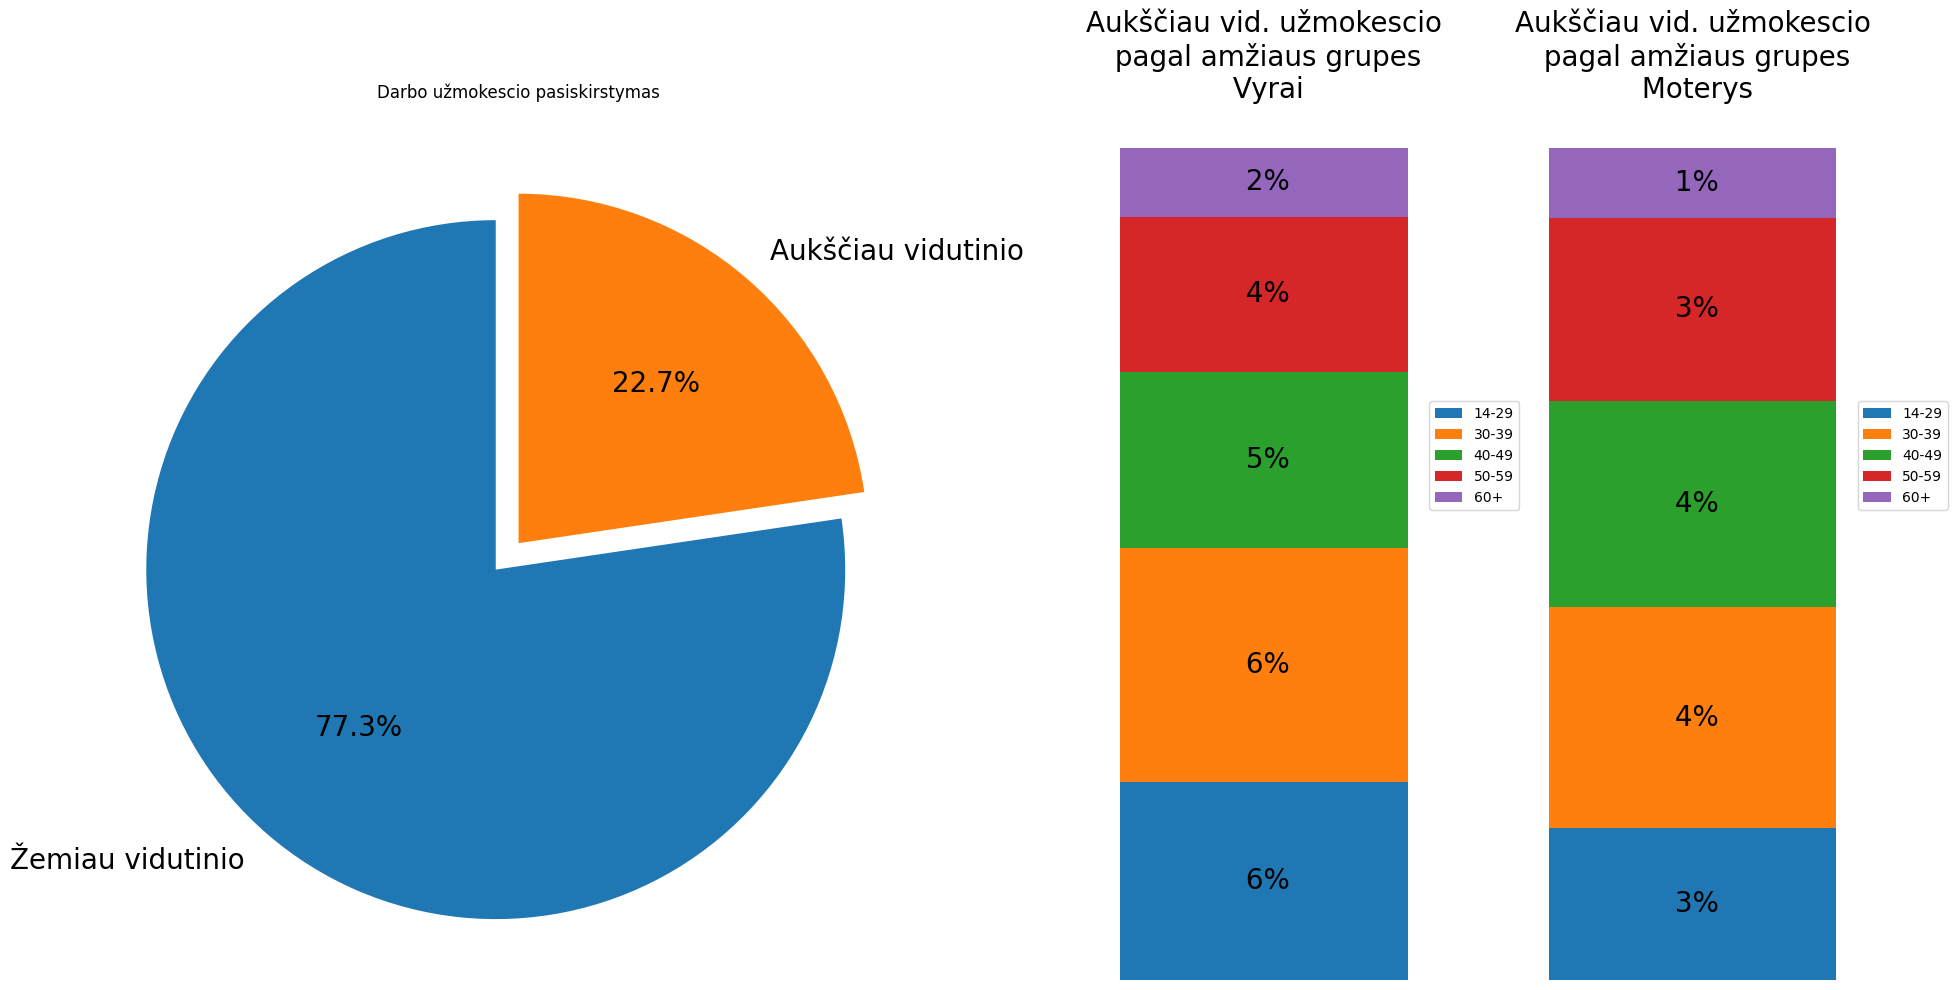

In [58]:
# parašykite funkciją,kuriai galėtumėte nurodyti savo norimus duomenis kaip list arba array
#  ir ji nubraižytų bar-of-pie tipo grafiką. Rodo paskirstyma pagal amziaus 
# grupes tiek daugiau, tiek maziau uz vidutini gaunancius. Bei PAGAL LYTI.
#  funkcijos pavadinimas BarOfPie(), argumentus, jų tipus parenkate patys

# https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html

import matplotlib.pyplot as plt

def BarOfPie(pie=[], bar_M=[], bar_F=[], bar_1_M=[], bar_1_F=[], pie_labels=[], bar_labels=[], explode_index: int=0):
    # Sukuriame subplots su skirtingu dydžių santykiu (3:1:1)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10), gridspec_kw={'width_ratios': [3, 1, 1]})

    # Pagrindinė diagrama (Pyragas)
    explode = [0.1 if i == explode_index else 0 for i in range(len(pie))]
    wedges, texts, autotexts = ax1.pie(pie, labels=pie_labels, autopct='%1.1f%%', startangle=90, explode=explode, textprops={'fontsize': 20})
    ax1.set_title("Darbo užmokescio pasiskirstymas")

    # Pasirenkame, kokius duomenis rodyti bar grafike
    if explode_index == 0:
        bar_data_M = bar_M  # Aukščiau vid. darbo užmokestis Vyrai
        bar_data_F = bar_F  # Aukščiau vid. darbo užmokestis Moterys
        ax2.set_title("Aukščiau vid. užmokescio\n pagal amžiaus grupes\n Vyrai", fontsize=20)
        ax3.set_title("Aukščiau vid. užmokescio\n pagal amžiaus grupes\n Moterys", fontsize=20)
    else:
        bar_data_M = bar_1_M  # Žemiau vid. darbo užmokestis Vyrai
        bar_data_F = bar_1_F  # Žemiau vid. darbo užmokestis Moterys
        ax2.set_title("Žemiau vid užmokescio\n pagal amžiaus grupes\n Vyrai", fontsize=20)
        ax3.set_title("Žemiau vid užmokescio\n pagal amžiaus grupes\n Moterys", fontsize=20)

    # Barų diagrama vyrams (sukrautos juostos)
    bottom_M = 0
    width = 0.5  # Barų plotis
    for height, label in zip(bar_data_M, bar_labels):
        bc = ax2.bar(0, height, width, bottom=bottom_M, label=label)  # Visos juostos sukraunamos ant x = 0
        bottom_M += height  # Kiekvieną kartą padidiname apatinę ribą (sukrauname juostas)
        ax2.bar_label(bc, labels=[f"{height:2.0f}%"], label_type='center', fontsize=20)

    # Barų diagrama moterims (sukrautos juostos)
    bottom_F = 0
    for height, label in zip(bar_data_F, bar_labels):
        bc_1 = ax3.bar(0, height, width, bottom=bottom_F, label=label)  # Visos juostos sukraunamos ant x = 0
        bottom_F += height  # Kiekvieną kartą padidiname apatinę ribą (sukrauname juostas)
        ax3.bar_label(bc_1, labels=[f"{height:2.0f}%"], label_type='center', fontsize=20)

    # Pašaliname ašis ir jų žymes
    ax2.axis('off')  # Visiškai pašaliname ašis 
    ax3.axis('off')

    # Papildomi nustatymai
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.6)) 
    ax3.legend(loc="center left", bbox_to_anchor=(1, 0.6))  # Paaiškina, kokios amžiaus grupės

    # Parodome tris grafikus
    plt.tight_layout()
    plt.show()

# Naudojimo pavyzdys
pie = [77.34, 22.66]  # Pyrago diagramos duomenys
pie_labels = ['Žemiau vidutinio', 'Aukščiau vidutinio']
bar_M = [5.50, 6.49, 4.91, 4.30, 1.91]  # Aukščiau vid. Vyrai
bar_F = [2.80, 4.05, 3.80, 3.37, 1.28]  # Aukščiau vid. Moterys
bar_1_M = [6.71, 5.47, 6.10, 6.98, 4.14]  # Žemiau vid. Vyrai
bar_1_F = [7.15, 5.49, 7.02, 8.64, 4.37]  # Žemiau vid. Moterys
bar_labels = ['14-29', '30-39', '40-49', '50-59', '60+']

# Kvietimas
BarOfPie(pie=pie, bar_M=bar_M, bar_F=bar_F, bar_1_M=bar_1_M, bar_1_F=bar_1_F, pie_labels=pie_labels, bar_labels=bar_labels, explode_index=0)

   amzius lytis   lygis  count  procentine_dalis
0   14-29     M    virs   2179          5.048188
1   14-29     M  zemiau   2898          6.713928
2   14-29     F    virs   1206          2.793995
3   14-29     F  zemiau   3085          7.147160
4   30-39     M    virs   2801          6.489204
5   30-39     M  zemiau   2363          5.474469
6   30-39     F    virs   1750          4.054305
7   30-39     F  zemiau   2368          5.486053
8   40-49     M    virs   2120          4.911500
9   40-49     M  zemiau   2631          6.095357
10  40-49     F    virs   1639          3.797146
11  40-49     F  zemiau   3031          7.022055
12  50-59     M    virs   1858          4.304513
13  50-59     M  zemiau   3012          6.978037
14  50-59     F    virs   1456          3.373181
15  50-59     F  zemiau   3730          8.641460
16    60+     M    virs    825          1.911315
17    60+     M  zemiau   1789          4.144658
18    60+     F    virs    538          1.246409
19    60+     F  zem

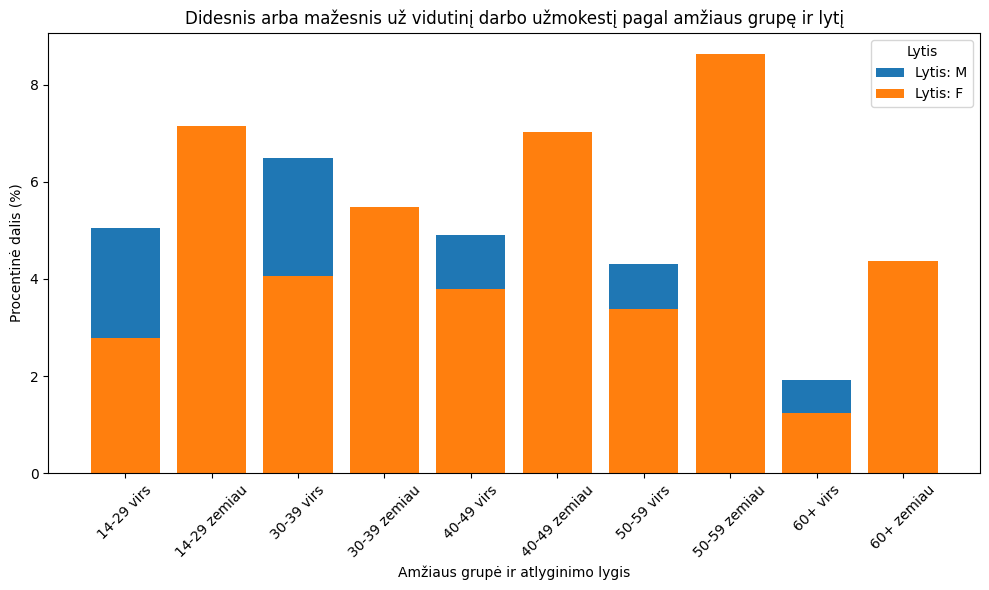

In [4]:
# Padaryta taip, kad gautume info, kiek procentais kiek%ienoje grupeje moteru ia vyru gauna maziau nei vidutinis
# 2) atsižvelkite į amžiaus grupes, irgi lyginame su visa imtimi kiekvieną amžiaus grupę

import pandas as pd
import matplotlib.pyplot as plt

# Įkelkite duomenis
df = pd.read_csv('../../DATA/DUS2018.csv')

# Suskaičiuojame vidutinį atlyginimą
vidutine_alga = df['bdu_spalio'].mean()

# Apskaičiuojame bendrą dalyvių skaičių
dalyviai = len(df)

# Apibrėžkite amžiaus grupes
age_groups = ['14-29', '30-39', '40-49', '50-59', '60+']

# Sukurti tuščią sąrašą rezultatams saugoti
results = []

# Iteruoti per kiekvieną amžiaus grupę ir lytį
for age_group in age_groups:
    for gender in ['M', 'F']:
        # Filtruojame dalyvius pagal amžiaus grupę, lytį ir didesnį nei vidutinį atlyginimą
        group_with_higher_salary = df[(df['amzius'] == age_group) & 
                                      (df['lytis'] == gender) & 
                                      (df['bdu_spalio'] >= vidutine_alga)]
        group_with_lower_salary = df[(df['amzius'] == age_group) & 
                                      (df['lytis'] == gender) & 
                                      (df['bdu_spalio'] < vidutine_alga)]
        
        # Pridedame rezultatus į sąrašą su procentine dalimi nuo visų dalyvių
        results.append({
            'amzius': age_group, 
            'lytis': gender, 
            'lygis': 'virs',  # Virš vidutinio
            'count': len(group_with_higher_salary),
            'procentine_dalis': (len(group_with_higher_salary) / dalyviai) * 100
        })
        
        results.append({
            'amzius': age_group, 
            'lytis': gender, 
            'lygis': 'zemiau',  # Žemiau vidutinio
            'count': len(group_with_lower_salary),
            'procentine_dalis': (len(group_with_lower_salary) / dalyviai) * 100
        })

# Konvertuoti rezultatus į DataFrame
ATS = pd.DataFrame(results)

# Išvesti rezultatus
print(ATS)

# Braižome grafikus
plt.figure(figsize=(10, 6))

for gender in ['M', 'F']:
    subset = ATS[ATS['lytis'] == gender]
    plt.bar(subset['amzius'] + ' ' + subset['lygis'], subset['procentine_dalis'], label=f'Lytis: {gender}')

# Grafiko nustatymai
plt.xlabel('Amžiaus grupė ir atlyginimo lygis')
plt.ylabel('Procentinė dalis (%)')
plt.title('Didesnis arba mažesnis už vidutinį darbo užmokestį pagal amžiaus grupę ir lytį')
plt.legend(title='Lytis')
plt.xticks(rotation=45)
plt.tight_layout()
